In [1]:
from rich import print
import pandas as pd
from copy import deepcopy


import wntr
from wntr.network import LinkStatus, WaterNetworkModel
from wntr.network.controls import ControlAction, Control, Comparison
from wntr.sim import EpanetSimulator

In [2]:
wn = WaterNetworkModel("../networks/any-town.inp")
node_name_list = ['50','90','170']
pump_name_list = sorted(wn.pump_name_list, key=lambda x: int(x))
tank_name_list = sorted(wn.tank_name_list, key=lambda x: int(x))

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def sim_create_df(pressures, tank_levels):
    pressures_df = {'node':[], 'time':[], 'pressure':[]}
    for node, pressure in pressures.items():
        if node not in node_name_list:
            continue
        for t, p in pressure.items():
            pressures_df['node'].append(node)
            pressures_df['time'].append(t)
            pressures_df['pressure'].append(p)
    pressures_df = pd.DataFrame(pressures_df)    

    tank_levels_df = {'tank':[], 'time':[], 'level':[]}
    for tank, level in tank_levels.items():
        if tank not in tank_name_list:
            continue
        for t, l in level.items():
            tank_levels_df['tank'].append(tank)
            tank_levels_df['time'].append(t)
            tank_levels_df['level'].append(l)
    tank_levels_df = pd.DataFrame(tank_levels_df)
    return pressures_df, tank_levels_df


def sim_plot(pressures_df, tank_levels_df, duration):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    fig.suptitle(f"Pressures and Tank Levels (duration: {duration}s)")

    # Plot pressures
    sns.lineplot(data=pressures_df, x='time', y='pressure', hue='node', ax=ax1)
    ax1.set_title('Pressures')
    ax1.set_ylabel('Pressure')

    # Plot tank levels
    sns.lineplot(data=tank_levels_df, x='time', y='level', hue='tank', ax=ax2)
    ax2.set_title('Tank Levels')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Level')

    plt.tight_layout()
    plt.show()


def sim_run(wn: WaterNetworkModel, duration: int, verbose: bool = False):
    wn.options.time.duration = duration
    sim = EpanetSimulator(wn)
    out = sim.run_sim()
    pressures = out.node['pressure'].to_dict()
    tank_levels = out.node['head'].to_dict()
    if not verbose:
        return pressures, tank_levels

    pressures_df, tank_levels_df = sim_create_df(pressures, tank_levels)
    sim_plot(pressures_df, tank_levels_df, duration)
    return out


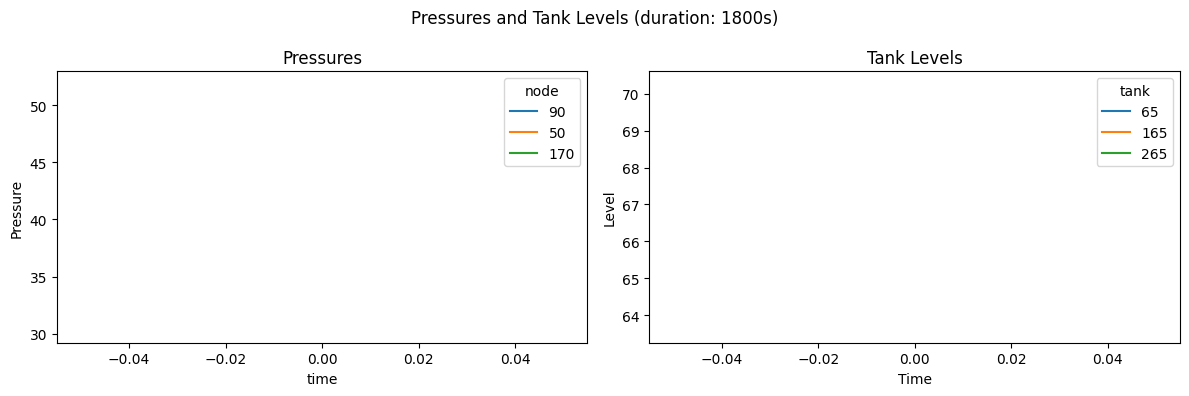

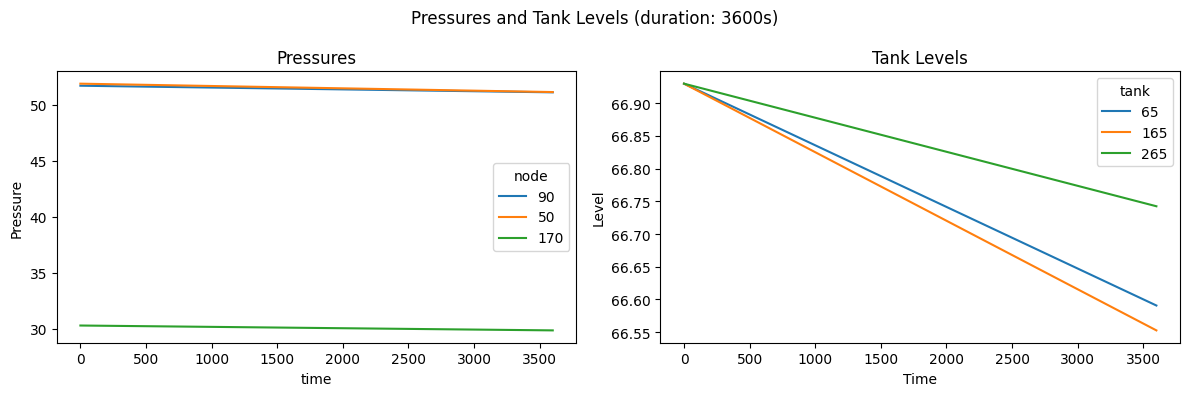

In [4]:
from wntr.network.controls import ControlAction, Control, TimeOfDayCondition, Comparison

def model_add_pump_control(wn: WaterNetworkModel, pump_name: str, status: LinkStatus, time: float) -> str:
    # check if the control already exists
    control_name = f"{time:05d}_{pump_name}_{status}"
    controls = list(wn.controls())
    for name, control in controls:
        if name == control_name:
            print(f"Control {control_name} already exists")
            return
    pump = wn.get_link(pump_name)
    threshold = time
    condition = TimeOfDayCondition(wn, Comparison.eq, threshold)
    action = ControlAction(target_obj=pump, attribute="status", value=status)
    control = Control(condition, then_action=action)
    wn.add_control(control_name, control)
    return control_name

def model_clean_controls(wn: WaterNetworkModel):
    control_name_list = [control_name for control_name, _ in wn.controls()]
    for control_name in control_name_list:
        wn.remove_control(control_name)

model_clean_controls(wn)
control_name_list = []
control_name_list.append(model_add_pump_control(wn, pump_name_list[0], LinkStatus.Opened, 0))
# control_name_list.append(model_add_pump_control(wn, pump_name_list[1], LinkStatus.Opened, 0))
# control_name_list.append(model_add_pump_control(wn, pump_name_list[2], LinkStatus.Opened, 0))

sim_run(wn, 1800, True)
sim_run(wn, 3600, True)

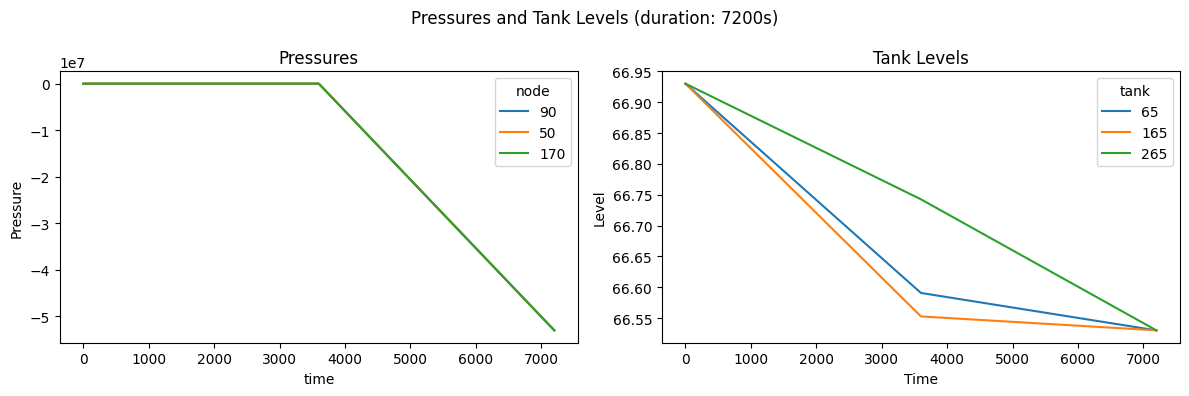

In [5]:
wn_copy = deepcopy(wn)
sim_run(wn_copy, 7200, True)

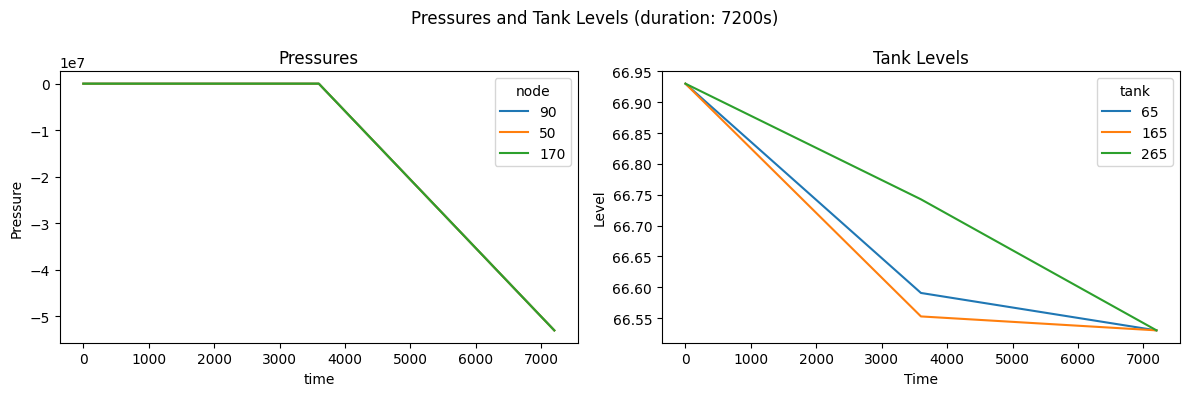

In [6]:
wn_copy = deepcopy(wn)
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.Opened, 3600))
sim_run(wn_copy, 7200, True)

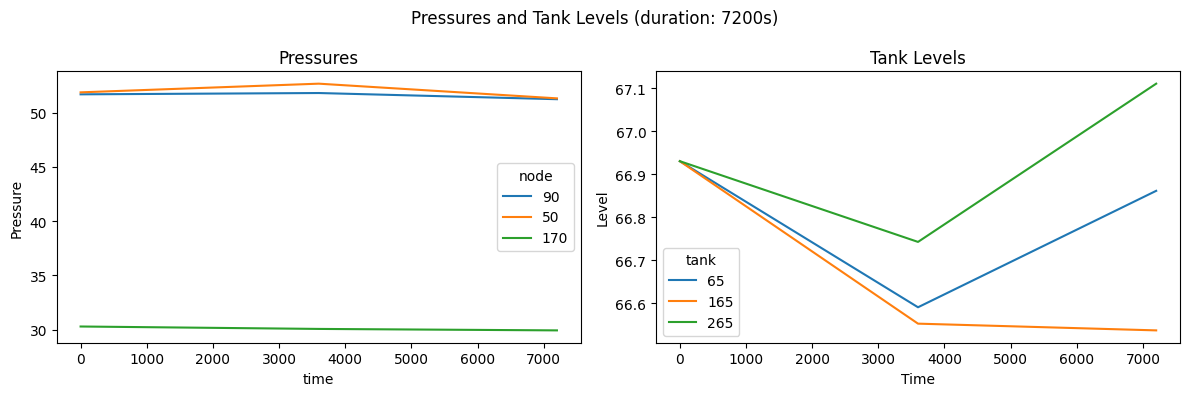

In [7]:

wn_copy = deepcopy(wn)
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.Opened, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[1], LinkStatus.Opened, 3600))
sim_run(wn_copy, 7200, True)

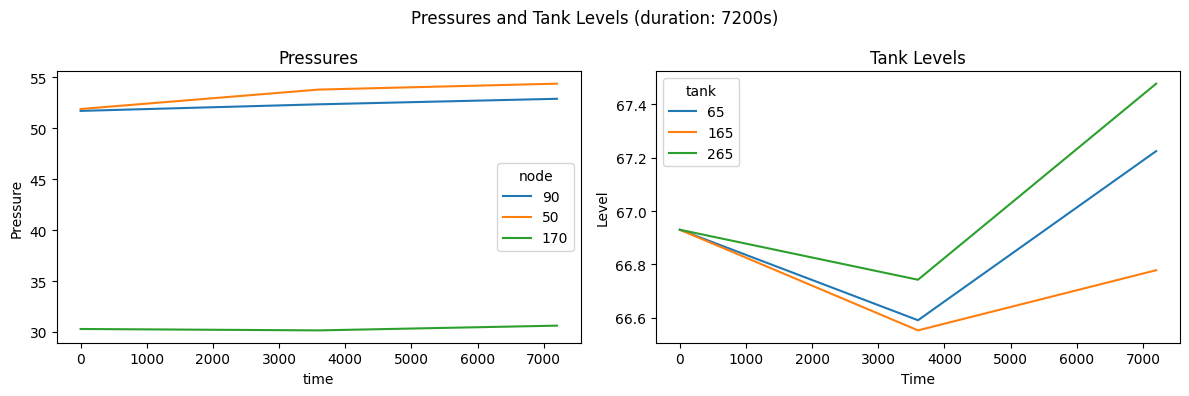

In [8]:

wn_copy = deepcopy(wn)
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.Opened, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[1], LinkStatus.Opened, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[2], LinkStatus.Opened, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.Opened, 3600 * 2))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[1], LinkStatus.Opened, 3600 * 2))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[2], LinkStatus.Opened, 3600 * 2))
out = sim_run(wn_copy, 2 * 3600, True)


In [27]:
prices = wn.get_pattern("PRICES").multipliers
print(prices)
n = len(energy['111'])
watts = energy['111'] / (1000 * 3600)
print(watts.tolist())
cost = (watts * (prices[:n] / 100)).sum()
print(f"Cost: {cost}")

[18.14 18.14 18.14 18.14 18.14 18.14 18.14 35.28 35.28 35.28 35.28 35.28 35.28 35.28 35.28 35.28 35.28 80.97 80.97 
80.97 80.97 18.14 18.14 18.14]

[518.6300519285262, 379.7843346214534, 375.9178133684615]

Cost: 231.1638610652052

'node keys:'

dict_keys(['demand', 'head', 'pressure', 'quality'])

'link keys:'

dict_keys(['quality', 'flowrate', 'velocity', 'headloss', 'status', 'setting', 'friction_factor', 'reaction_rate'])

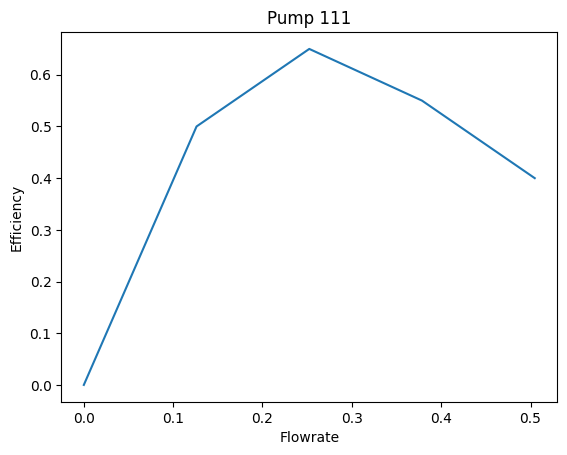

Pump 111 flowrate:

0       0.408566
3600    0.305001
7200    0.301943
Name: 111, dtype: float32

'energy       10                111  12  14  16  178  18   2  20  22  ...  64  66  68  \\\n0    NaN  1867068186.942694 NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN NaN NaN   \n3600 NaN  1367223604.637232 NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN NaN NaN   \n7200 NaN  1353304128.126462 NaN NaN NaN  NaN NaN NaN NaN NaN  ... NaN NaN NaN   \n\n      70  72  74  76  78   8  80  \n0    NaN NaN NaN NaN NaN NaN NaN  \n3600 NaN NaN NaN NaN NaN NaN NaN  \n7200 NaN NaN NaN NaN NaN NaN NaN  \n\n[3 rows x 44 columns]'

NotImplementedError: WNTR does not support price patterns yet.

In [11]:
display('node keys:', out.node.keys())
display('link keys:', out.link.keys())
# display pump.efficiency
pump_name = pump_name_list[0]
for pump_name, pump in wn_copy.pumps():
    if pump_name != pump_name_list[0]:
        continue
    curve = wn.get_curve(pump.efficiency)
    x = [point[0] for point in curve.points]
    y = [point[1]/100.0 for point in curve.points]
    plt.plot(x, y)
    plt.xlabel('Flowrate')
    plt.ylabel('Efficiency')
    plt.title(f"Pump {pump_name}")
    plt.show()
    break
# display flowrate
print(f"Pump {pump_name} flowrate:")
display(out.link['flowrate'][pump_name])

energy = wntr.metrics.pump_energy(out.link['flowrate'], out.node['head'], wn_copy)
display(f"energy {energy}")
cost = wntr.metrics.pump_cost(energy, wn_copy)
display(cost)